# Code draft for reading weather file and predict beach crowd from a weather data file

***B. Castelle (EPOC-CNRS) - April 2025***

This notebook reads a weather file to compute beach crowd from a pre-built XGBoost model - to be further developped (internship Clément Benony) to read weather data from API and print outputs on a website

Follow the sections for step-by-step insights.

***______________________________________________________________________________________________________________***


***Get Libraries***

In [15]:
import pandas as pd
import xgboost as xgb
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import requests

In [43]:
URL_GET_WAVE = 'https://marine-api.open-meteo.com/v1/marine?latitude=44.446321&longitude=-1.256297&hourly=wave_height,wave_direction,swell_wave_peak_period&timezone=auto'
URL_GET_WEATHER = 'https://api.open-meteo.com/v1/forecast?latitude=44.458336&longitude=-1.2916565&hourly=temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_direction_10m&timezone=auto&wind_speed_unit=ms'
r1 = requests.get(URL_GET_WAVE)
r2 = requests.get(URL_GET_WEATHER)
data1 = r1.json()
data2 =r2.json()


print(data1)
print(' ')
print(data2)

{'latitude': 44.458336, 'longitude': -1.2916565, 'generationtime_ms': 0.10585784912109375, 'utc_offset_seconds': 7200, 'timezone': 'Europe/Paris', 'timezone_abbreviation': 'GMT+2', 'elevation': 0.0, 'hourly_units': {'time': 'iso8601', 'wave_height': 'm', 'wave_direction': '°', 'swell_wave_peak_period': 's'}, 'hourly': {'time': ['2025-04-24T00:00', '2025-04-24T01:00', '2025-04-24T02:00', '2025-04-24T03:00', '2025-04-24T04:00', '2025-04-24T05:00', '2025-04-24T06:00', '2025-04-24T07:00', '2025-04-24T08:00', '2025-04-24T09:00', '2025-04-24T10:00', '2025-04-24T11:00', '2025-04-24T12:00', '2025-04-24T13:00', '2025-04-24T14:00', '2025-04-24T15:00', '2025-04-24T16:00', '2025-04-24T17:00', '2025-04-24T18:00', '2025-04-24T19:00', '2025-04-24T20:00', '2025-04-24T21:00', '2025-04-24T22:00', '2025-04-24T23:00', '2025-04-25T00:00', '2025-04-25T01:00', '2025-04-25T02:00', '2025-04-25T03:00', '2025-04-25T04:00', '2025-04-25T05:00', '2025-04-25T06:00', '2025-04-25T07:00', '2025-04-25T08:00', '2025-04-2

***Prepare input data - Note that all the following subsections will need to be changed i.e. read API instead !***

Model, weather and tide input data files and directories

In [4]:
## Time period for the forecast
start_date = pd.to_datetime('2023-08-08')
end_date = pd.to_datetime('2023-08-12')
## Interpolation time step in minutes
dt = 10

################################
# Model parameters 
################################

# Beach user count
# See Castelle et al. (submitted, O&CM) for details
S1, S2, S3, S4 = 5, 20, 50, 90  # Treshold (in %) of totation potential attendance
max_crowd=2300 # Maximum potential attendance (a bit subjective)

# Rip current forecast model
# Below are the optimal values found at Biscarrosse Beach - See Castelle et al. (2025, NHESS)
g = 9.81  # gravity [m/s²]
gamma = 0.23 # breaker parameter
z_bar = -3.0  # sandbar elevation
d = 6.5 # channel depth
theta_c = 284.1  # Coastline orientation
SR1, SR2, SR3, SR4 = 0.3006, 0.9107, 1.3764, 1.8915

# Shore-break wave forecast model
dx = 2.0  # cross-shore grid spacing of the idealized beach profile
x = np.arange(0, 1000 + dx, dx)  # +dx to include 1000
# Constants and parameters
gamma_s = 0.4 # Breaker parameter
b = -2.75 # b and c define beach shape
c = 0.3
Zl = -2 # terrace elevation
e = 2
grav = 9.81
dx = x[1] - x[0]

# Beach profile and slope
z = 5 + b * x**c
SS1, SS2, SS3, SS4 = 1.7607, 2.9321, 5.1730, 8.6697

#################################
# Files and directories
################################
# XGBoost Model to be used
model_filename="xgboost_model_SUMMER_RR1_dm-T_dm-FF_dm-DD_dm-INS_dm-Day-Month-Hour.json"
model_path="Models"
Input_Vars=['RR1_dm','T_dm','FF_dm','DD_dm','INS_dm','Day','Month','Hour']
# Input Weather data
weather_data_path = "Weather"  # Update with your actual file name
weather_filename="Example.csv"
# Inpute Wave data
wave_data_path = "Vagues"
wave_filename = "vagues_exposition_biscarrosse.csv"
# Input Tide data
tide_data_path = "Maree/"
tide_filename="Biscarrosse.txt"


# To compute daily-mean values
start_hour = 10
end_hour = 18

Loading weather, wave and tide data, as well as their daily-mean values

In [45]:
####################################
#### Weather
##############
full_weather_path = os.path.join(weather_data_path, weather_filename)
# Column names and loading
weather_columns = ['POSTE', 'DATE', 'RR1', 'T', 'FF', 'DD', 'INS']
weather_data = pd.read_csv(full_weather_path, sep=',', names=weather_columns, header=0)
# Datetime conversion
weather_data['Time_Meteo'] = pd.to_datetime(weather_data['DATE'], format='%Y%m%d%H')
weather_data = weather_data[['Time_Meteo', 'RR1', 'T', 'FF', 'DD', 'INS']]
print(weather_data.head())
# Extract hour and date
weather_data['Hour'] = weather_data['Time_Meteo'].dt.hour
weather_data['Date'] = weather_data['Time_Meteo'].dt.date
# Filter based on time range
daily_mean_data = weather_data[(weather_data['Hour'] >= start_hour) & (weather_data['Hour'] < end_hour)]
# Compute daily means
for col in ['RR1', 'T', 'FF', 'DD', 'INS']:
    mean_col = f"{col}_dm"
    daily_mean = daily_mean_data.groupby('Date')[col].mean().reset_index()
    daily_mean.rename(columns={col: mean_col}, inplace=True)
    weather_data = pd.merge(weather_data, daily_mean, on='Date', how='left')

# Add date-based features
weather_data['Day'] = weather_data['Time_Meteo'].dt.day
weather_data['Month'] = weather_data['Time_Meteo'].dt.month
# Keep only required columns
#final_columns = ['RR1_dm', 'T_dm', 'FF_dm', 'DD_dm', 'INS_dm', 'Day', 'Month', 'Hour']
#final_columns = ['RR1', 'T', 'FF', 'DD', 'INS','RR1_dm', 'T_dm', 'FF_dm', 'DD_dm', 'INS_dm', 'Day', 'Month', 'Hour']
final_columns = ['Time_Meteo', 'RR1', 'T', 'FF', 'DD', 'INS',
                 'RR1_dm', 'T_dm', 'FF_dm', 'DD_dm', 'INS_dm',
                 'Day', 'Month', 'Hour']
weather_data = weather_data[final_columns]

## Ensure numeric
#for col in final_columns:
#    weather_data[col] = pd.to_numeric(weather_data[col], errors='coerce')

print("Weather columns after loading:", weather_data.columns)

# Drop any rows with missing values (optional but recommended)
weather_data.dropna(inplace=True)

print(weather_data.head())


##########################################################################################################
#### Waves
##############
# Load wave data
wave_file_path = os.path.join(wave_data_path, wave_filename)
wave_columns = ['Beach', 'Date', 'Hour', 'Hs', 'Tp', 'Dir']
waves_data = pd.read_csv(wave_file_path, sep=';', names=wave_columns, header=0)
# Ensure 'Hour' is two digits for datetime parsing
waves_data['Hour'] = waves_data['Hour'].apply(lambda x: str(x).zfill(2))
# Create full datetime column BEFORE dropping anything
waves_data['Waves_Time'] = pd.to_datetime(waves_data['Date'] + ' ' + waves_data['Hour'], format='%Y-%m-%d %H')
# Convert numeric columns
waves_data[['Hs', 'Tp', 'Dir']] = waves_data[['Hs', 'Tp', 'Dir']].apply(pd.to_numeric, errors='coerce')
# Extract new hour/date columns for grouping
waves_data['Hour'] = waves_data['Waves_Time'].dt.hour
waves_data['Date'] = waves_data['Waves_Time'].dt.date
# Compute daily means
daily_mean_waves_data = waves_data[(waves_data['Hour'] >= start_hour) & (waves_data['Hour'] < end_hour)]

for col in ['Hs', 'Tp', 'Dir']:
    daily_mean = daily_mean_waves_data.groupby('Date')[col].mean().reset_index()
    daily_mean.rename(columns={col: f'{col}_dm'}, inplace=True)
    waves_data = pd.merge(waves_data, daily_mean, on='Date', how='left')

# Now it's safe to drop columns you don't need (but NOT Waves_Time!)
waves_data = waves_data.drop(columns=['Beach', 'Date', 'Hour'])
#print(waves_data.head())


##########################################################################################################
#### Tide
##############
tide_file_path = os.path.join(tide_data_path, tide_filename)
tide_columns = ['Day', 'Hour', 'Eta']
tide_data = pd.read_csv(tide_file_path, sep=' ', names=tide_columns, header=None)
tide_data['Time_Tide'] = pd.to_datetime(tide_data['Day'] + ' ' + tide_data['Hour'], format='%Y-%m-%d %H:%M')
tide_data = tide_data[['Time_Tide', 'Eta']]
tide_data['Eta'] = pd.to_numeric(tide_data['Eta'], errors='coerce')

# Add tidal range of the day
tide_data['Date'] = tide_data['Time_Tide'].dt.date
daily_range_eta = tide_data.groupby('Date')['Eta'].agg(lambda x: x.max() - x.min()).reset_index()
daily_range_eta.rename(columns={'Eta': 'TR'}, inplace=True)
tide_data = pd.merge(tide_data, daily_range_eta, on='Date', how='left')
tide_data = tide_data.drop(columns=['Date'])

print('----------------')
print('tide')
print(tide_data.head())

           Time_Meteo  RR1     T   FF   DD  INS
0 2023-08-08 01:00:00    0  17.1  3.9   70    0
1 2023-08-08 02:00:00    0  16.7  4.5   80    0
2 2023-08-08 03:00:00    0  16.4  4.5   80    0
3 2023-08-08 04:00:00    0  16.0  4.2   90    0
4 2023-08-08 05:00:00    0  15.3  4.1  100    0
Weather columns after loading: Index(['Time_Meteo', 'RR1', 'T', 'FF', 'DD', 'INS', 'RR1_dm', 'T_dm', 'FF_dm',
       'DD_dm', 'INS_dm', 'Day', 'Month', 'Hour'],
      dtype='object')
           Time_Meteo  RR1     T   FF   DD  INS  RR1_dm  T_dm   FF_dm  DD_dm  \
0 2023-08-08 01:00:00    0  17.1  3.9   70    0     0.0  25.7  5.3375  310.0   
1 2023-08-08 02:00:00    0  16.7  4.5   80    0     0.0  25.7  5.3375  310.0   
2 2023-08-08 03:00:00    0  16.4  4.5   80    0     0.0  25.7  5.3375  310.0   
3 2023-08-08 04:00:00    0  16.0  4.2   90    0     0.0  25.7  5.3375  310.0   
4 2023-08-08 05:00:00    0  15.3  4.1  100    0     0.0  25.7  5.3375  310.0   

   INS_dm  Day  Month  Hour  
0    60.0    8    

Interpolate all the data at time step dt, from start_date to end_date

In [6]:
# Create time index for interpolation
time_index = pd.date_range(start=start_date, end=end_date, freq=f'{dt}min')
interpolation_df = pd.DataFrame(index=time_index)
interpolation_df['Datetime'] = interpolation_df.index
interpolation_df['Day'] = interpolation_df['Datetime'].dt.day
interpolation_df['Month'] = interpolation_df['Datetime'].dt.month
interpolation_df['Hour'] = interpolation_df['Datetime'].dt.hour + interpolation_df['Datetime'].dt.minute / 60

# Set datetime index and interpolate weather data
weather_data.set_index('Time_Meteo', inplace=True)
#weather_interp = weather_data[Input_Vars].reindex(time_index).interpolate(method='time')
#weather_interp = weather_data.reindex(time_index).interpolate(method='time')
#weather_interp = weather_data['RR1', 'T', 'FF', 'DD', 'INS','RR1_dm', 'T_dm', 'FF_dm', 'DD_dm', 'INS_dm', 'Day', 'Month', 'Hour'].reindex(time_index).interpolate(method='time')
weather_interp = weather_data.reindex(time_index).interpolate(method='time')


# Same for wave data
# Debugging step: Check for Waves_Time
if 'Waves_Time' not in waves_data.columns:
    print("Waves_Time column missing! Available columns:", waves_data.columns)
    raise ValueError("Missing 'Waves_Time' in waves_data. Check data processing above.")
waves_data.set_index('Waves_Time', inplace=True)
#waves_interp = waves_data[['Hs_dm', 'Tp_dm', 'Dir_dm']].reindex(time_index).interpolate(method='time')
waves_interp = waves_data.reindex(time_index).interpolate(method='time')
# Same for tide data
tide_data.set_index('Time_Tide', inplace=True)
#tide_interp = tide_data[['TR']].reindex(time_index).interpolate(method='time')
tide_interp = tide_data.reindex(time_index).interpolate(method='time')
# Drop duplicate time-related columns from weather_interp
weather_interp = weather_interp.drop(columns=['Day', 'Month', 'Hour'], errors='ignore')
# Merge all dataframes on the same index
combined_data = pd.concat([interpolation_df, weather_interp, waves_interp, tide_interp], axis=1)
# Drop rows with any missing values (optional but helps XGBoost)
combined_data.dropna(inplace=True)





***

***DATA MATRX DONE !!! - This one is key to compute the beach attendance and hazards in the next sectios

In [7]:

# Cool, we have now all our input data in one dataset (coimbined_data), which variables will be 
# used to forecast beach user count and rip-current and shore-break wave hazards !!!

# Print the head of the variable matrics to check what is in there
print(combined_data.head())


                               Datetime  Day  Month      Hour  RR1          T  \
2023-08-08 01:00:00 2023-08-08 01:00:00    8      8  1.000000  0.0  17.100000   
2023-08-08 01:10:00 2023-08-08 01:10:00    8      8  1.166667  0.0  17.033333   
2023-08-08 01:20:00 2023-08-08 01:20:00    8      8  1.333333  0.0  16.966667   
2023-08-08 01:30:00 2023-08-08 01:30:00    8      8  1.500000  0.0  16.900000   
2023-08-08 01:40:00 2023-08-08 01:40:00    8      8  1.666667  0.0  16.833333   

                      FF         DD  INS  RR1_dm  ...  DD_dm  INS_dm  \
2023-08-08 01:00:00  3.9  70.000000  0.0     0.0  ...  310.0    60.0   
2023-08-08 01:10:00  4.0  71.666667  0.0     0.0  ...  310.0    60.0   
2023-08-08 01:20:00  4.1  73.333333  0.0     0.0  ...  310.0    60.0   
2023-08-08 01:30:00  4.2  75.000000  0.0     0.0  ...  310.0    60.0   
2023-08-08 01:40:00  4.3  76.666667  0.0     0.0  ...  310.0    60.0   

                           Hs       Tp         Dir     Hs_dm   Tp_dm  Dir_dm  \


___________________________________________________________________________________

# BEACH ATTENDANCE FORECAST

***Load the otimized XGboost Model***

<bound method NDFrame.head of                        RR1_dm      T_dm     FF_dm     DD_dm    INS_dm  \
2023-08-08 01:00:00 -0.382913  0.509197 -0.085954  0.362067  1.049177   
2023-08-08 01:10:00 -0.382913  0.509197 -0.085954  0.362067  1.049177   
2023-08-08 01:20:00 -0.382913  0.509197 -0.085954  0.362067  1.049177   
2023-08-08 01:30:00 -0.382913  0.509197 -0.085954  0.362067  1.049177   
2023-08-08 01:40:00 -0.382913  0.509197 -0.085954  0.362067  1.049177   
...                       ...       ...       ...       ...       ...   
2023-08-11 23:20:00 -0.382913  0.197844 -0.417724  0.045421 -0.196465   
2023-08-11 23:30:00 -0.382913  0.110100 -0.419865 -0.020547 -0.559778   
2023-08-11 23:40:00 -0.382913  0.022355 -0.422005 -0.086515 -0.923090   
2023-08-11 23:50:00 -0.382913 -0.065390 -0.424146 -0.152483 -1.286402   
2023-08-12 00:00:00 -0.382913 -0.153135 -0.426286 -0.218451 -1.649715   

                          Day     Month      Hour  
2023-08-08 01:00:00  1.995929  1.002636 -

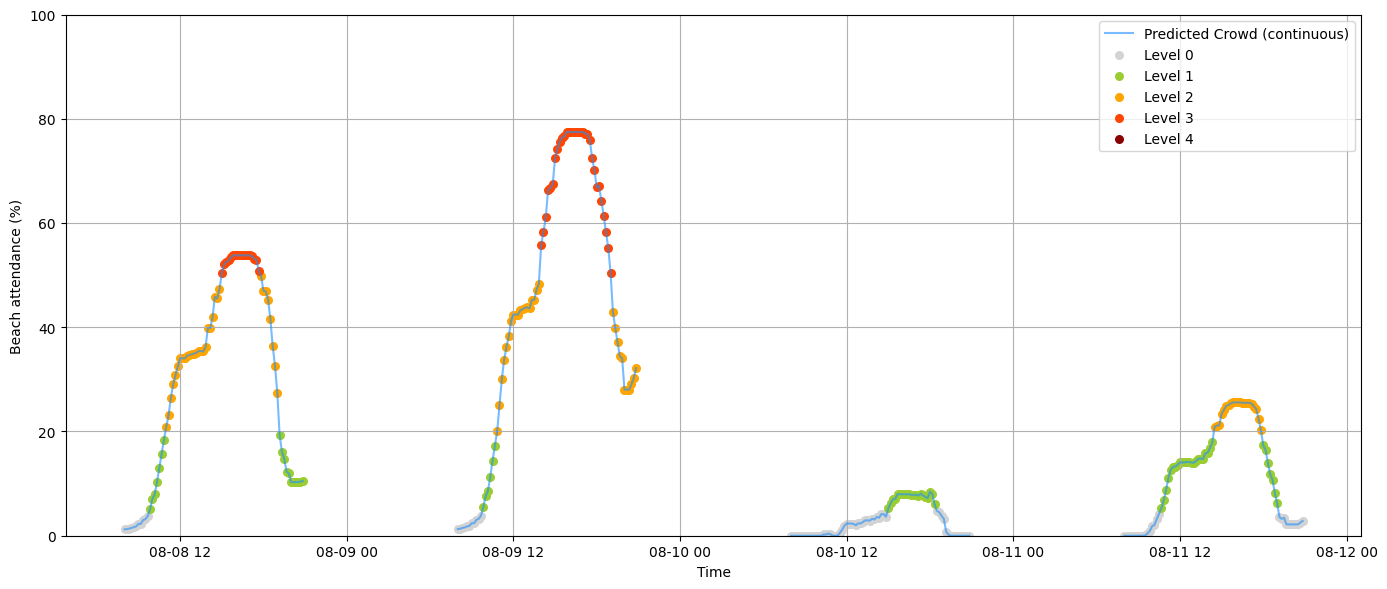

In [8]:

# Paths
model_filename = "xgboost_model_SUMMER.json"
model_path = "Models"
full_model_path = os.path.join(model_path, model_filename)

# Load model and make prediction
model = xgb.Booster()
model.load_model(full_model_path)

norm_filename = "normalization_params.pkl"
model_path = "Models"
full_norm_path = os.path.join(model_path, norm_filename)

# Load the normalization parameters
with open(full_norm_path, 'rb') as f:
    norm_params = pickle.load(f)

X_mean = norm_params['X_mean']
X_std = norm_params['X_std']
y_mean = norm_params['y_mean']
y_std = norm_params['y_std']
Input_Vars = norm_params['input_vars']


X_test = combined_data[Input_Vars]
X_test_normalized = (X_test - X_mean) / X_std

print(X_test_normalized.head)

dmat = xgb.DMatrix(X_test_normalized)
predictions = model.predict(dmat)
# Denormalize the predictions and actual values
def denormalize_target(y_normalized, mean, std):
    return (y_normalized * std) + mean
#predictions_denormalized = denormalize_target(predictions, y_mean, y_std)

# Convert predictions to a Series with the same index as combined_data
predictions_denormalized = pd.Series(denormalize_target(predictions, y_mean, y_std), index=combined_data.index)/(max_crowd/100)
# Mask predictions outside of 08:00 to 21:00
predictions_denormalized[(combined_data['Datetime'].dt.hour < 8) | (combined_data['Datetime'].dt.hour >= 21)] = np.nan
predictions_denormalized = predictions_denormalized.clip(lower=0)
predictions_denormalized = predictions_denormalized.clip(lower=0, upper=100)


# Initialize with NaN
pred_classes = pd.Series(index=predictions_denormalized.index, dtype='float')

# Apply thresholds
pred_classes[predictions_denormalized < S1] = 0
pred_classes[(predictions_denormalized >= S1) & (predictions_denormalized < S2)] = 1
pred_classes[(predictions_denormalized >= S2) & (predictions_denormalized < S3)] = 2
pred_classes[(predictions_denormalized >= S3) & (predictions_denormalized < S4)] = 3
pred_classes[predictions_denormalized >= S4] = 4

plt.figure(figsize=(14, 6))
plt.ylim(0, 100)
plt.plot(combined_data['Datetime'], predictions_denormalized, label='Predicted Crowd (continuous)', color='dodgerblue', linestyle='-', alpha=0.6)

# Optional: plot class predictions as scatter with color per class
colors = ['lightgrey', 'yellowgreen', 'orange', 'orangered', 'darkred']
for level in range(5):
    mask = pred_classes == level
    plt.scatter(combined_data['Datetime'][mask], predictions_denormalized[mask], 
                label=f'Level {level}', color=colors[level], s=30)

plt.xlabel("Time")
plt.ylabel("Beach attendance (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# SURF ZONE HAZARD FORECASTS !!!

***Rip Current***

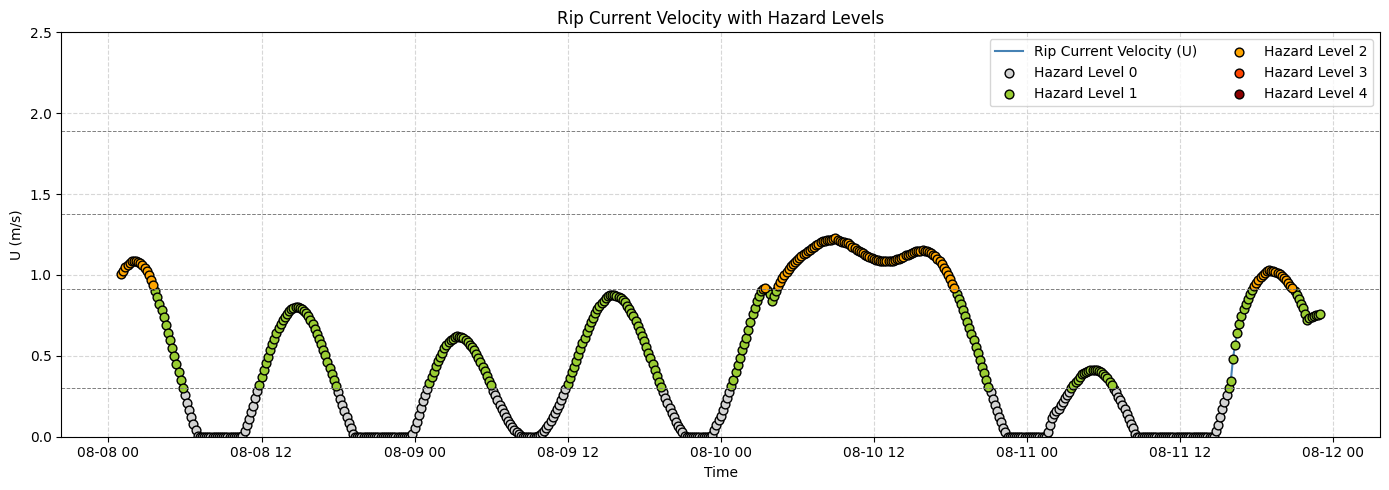

In [9]:

# Input variables from combined_data
Tide_Time = combined_data['Datetime'].values
Hs = combined_data['Hs'].values
Tp = combined_data['Tp'].values
Dir = combined_data['Dir'].values
Tide_Elevation = combined_data['Eta'].values

# Output arrays
Eta_b = np.full_like(Hs, np.nan)
Eta_c = np.full_like(Hs, np.nan)
U = np.full_like(Hs, np.nan)

import numpy as np

def dispersion_newton(T, d, precision=1e-4):
    """
    Solves the dispersion relation for water waves using Newton-Raphson method.
    w^2 = g * k * tanh(k * d)
    """
    g = 9.81
    w2 = (2 * np.pi / T)**2
    k = 0.5  # initial guess
    precision = abs(precision)
    dispe = 2 * precision

    while abs(dispe) > precision:
        tanh_kd = np.tanh(k * d)
        dispe = w2 - g * k * tanh_kd
        fdispe = -g * (tanh_kd + k * d * (1 - tanh_kd**2))
        k -= dispe / fdispe

    return k

def LarsonWaveRefractionAtBreaking(Hs0, Tp0, theta0, h0, gammab):
    """
    Larson wave refraction and breaking model.
    Based on Larson et al. (2010)
    """
    if h0 <= 0:
        raise ValueError("h0 cannot be negative or equal to 0")

    g = 9.81
    two_pi = 2 * np.pi

    # Ensure inputs are arrays for vector operations
    Hs0 = np.atleast_1d(Hs0)
    Tp0 = np.atleast_1d(Tp0)
    theta0 = np.atleast_1d(theta0)

    N = len(Hs0)
    Hsb = np.full(N, np.nan)
    thetab = np.full(N, np.nan)
    hb = np.full(N, np.nan)

    for i in range(N):
        if theta0[i] > 90:
            thetab[i] = 90
            Hsb[i] = 0
        elif theta0[i] < -90:
            thetab[i] = -90
            Hsb[i] = 0
        else:
            k0 = dispersion_newton(Tp0[i], h0)
            c0 = two_pi / (k0 * Tp0[i])
            cg0 = c0 * (0.5 + k0 * h0 / np.sinh(2 * k0 * h0))

            alpha = (c0 / np.sqrt(g * Hs0[i]))**4 * c0 * gammab**2 / cg0
            lambdaa = (np.cos(np.radians(theta0[i])) / alpha)**0.4
            epsi = (np.sin(np.radians(theta0[i])))**2 * lambdaa

            lambda_ = (1 + 0.1649 * epsi + 0.5948 * epsi**2 -
                       1.6787 * epsi**3 + 2.8573 * epsi**4) * lambdaa

            hb[i] = lambdaa * c0**2 / g
            Hsb[i] = hb[i] * gammab
            thetab[i] = np.degrees(np.arcsin(np.sqrt(lambda_) * np.sin(np.radians(theta0[i]))))

    return Hsb, thetab, hb



# Main loop
for i in range(len(Tide_Time) - 6):
    eta = Tide_Elevation[i]
    h = eta - z_bar
    H0 = Hs[i]
    T_period = Tp[i]
    Thet = Dir[i] - theta_c

    H0br, Thetbr, hbr = LarsonWaveRefractionAtBreaking(H0, T_period, Thet, 10, 0.7)
    H0 = H0br

    # Bar crest
    if h <= 0 or H0 <= gamma * h:
        Eta_b[i] = 0
    else:
        Eta_b[i] = 0.16 * (H0 - gamma * h) ** 2 / H0

    # Channel crest
    if (h + d) <= 0 or H0 <= gamma * (h + d):
        Eta_c[i] = 0
    else:
        Eta_c[i] = 0.16 * (H0 - gamma * (h + d)) ** 2 / H0

    Pg = max(0, Eta_b[i] - Eta_c[i])
    U[i] = np.sqrt(2 * g * Pg)

# Initialize Uh with zeros
Uh = np.zeros_like(U)

# Assign discrete hazard levels
Uh[(U >= SR1) & (U < SR2)] = 1
Uh[(U >= SR2) & (U < SR3)] = 2
Uh[(U >= SR3) & (U < SR4)] = 3
Uh[U >= SR4] = 4

# Color map for hazard levels
colors = ['lightgrey', 'yellowgreen', 'orange', 'orangered', 'darkred']

# Plotting
plt.figure(figsize=(14, 5))

# Continuous line for U
plt.plot(Tide_Time[:len(U)], U, color='steelblue', label='Rip Current Velocity (U)', zorder=1)

# Overlay colored circles for hazard levels
for level in range(5):  # levels 0 to 4
    idx = Uh == level
    plt.scatter(np.array(Tide_Time[:len(U)])[idx], np.array(U)[idx],
                color=colors[level], label=f'Hazard Level {level}', edgecolor='k', s=40, zorder=2)

plt.axhline(SR1, color='gray', linestyle='--', linewidth=0.7)
plt.axhline(SR2, color='gray', linestyle='--', linewidth=0.7)
plt.axhline(SR3, color='gray', linestyle='--', linewidth=0.7)
plt.axhline(SR4, color='gray', linestyle='--', linewidth=0.7)


plt.xlabel('Time')
plt.ylabel('U (m/s)')
plt.title('Rip Current Velocity with Hazard Levels')
plt.ylim(0, 2.5)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', ncol=2)
plt.tight_layout()
plt.show()



Shore-break waves

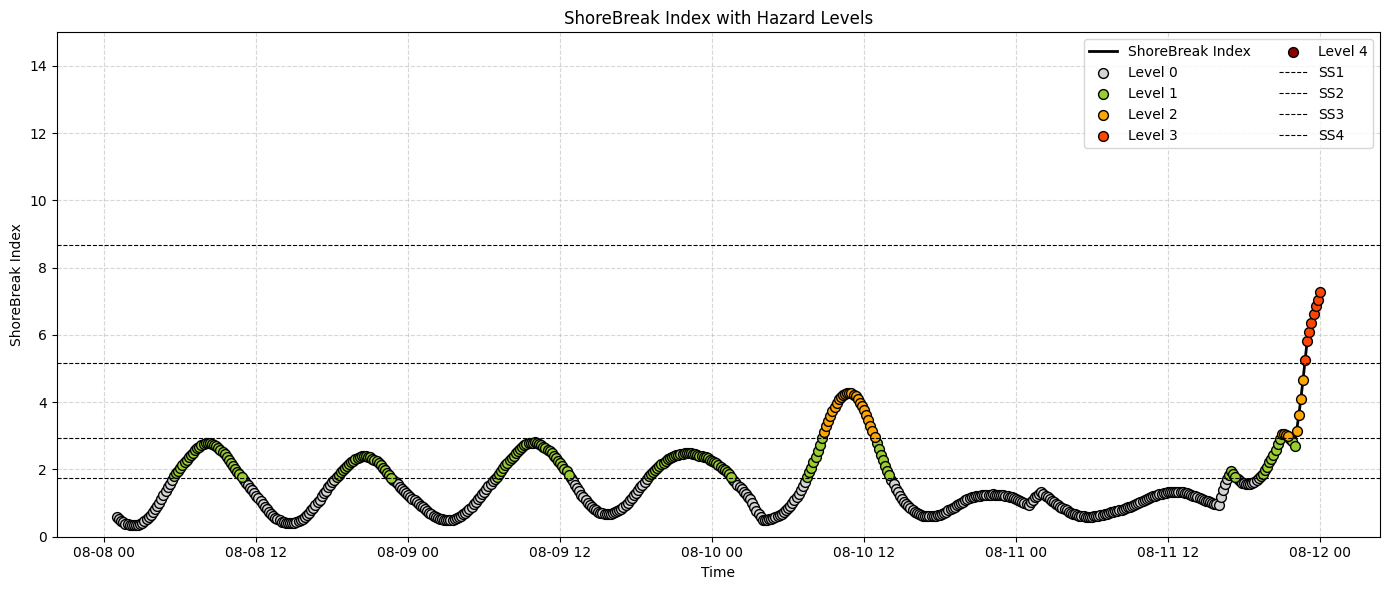

In [10]:
slope = -np.diff(z) / dx
elev = z[:-1]

# Preallocate arrays
N = len(Tide_Time)
TWL = Tide_Elevation[:N]
H0brv = np.full(N, np.nan)
Thetbrv = np.full(N, np.nan)
hbrv = np.full(N, np.nan)
L0 = np.full(N, np.nan)
Slope_t = np.full(N, np.nan)
Hbs = np.full(N, np.nan)
Irr = np.full(N, np.nan)
ShoreBreak_Index = np.full(N, np.nan)

# Loop over time steps
for i in range(N):
    eta = Tide_Elevation[i]
    h = eta - z_bar
    Thet = Dir[i] - theta_c

    # Refraction at breaking
    H0br, Thetbr, hbr = LarsonWaveRefractionAtBreaking(Hs[i], Tp[i], Thet, 10, 0.7)
    H0brv[i] = H0br
    Thetbrv[i] = Thetbr
    hbrv[i] = hbr
    L0[i] = grav * Tp[i]**2 / (2 * np.pi)

    # Shore break logic
    if eta < Zl:
        Slope_t[i] = 0
        Hbs[i] = 0
        Irr[i] = 0
    elif eta - H0br / gamma_s > Zl:
        Hbs[i] = H0br
        slope_interp = interp1d(elev, slope, bounds_error=False, fill_value=np.nan)
        Slope_t[i] = slope_interp(TWL[i])
        Irr[i] = Slope_t[i] / np.sqrt(Hbs[i] / L0[i])
    else:  # eta - H0br / gamma_s <= Zl
        Hbs[i] = H0br - (1 / H0br) * (H0br - gamma_s * (eta - Zl))**2
        slope_interp = interp1d(elev, slope, bounds_error=False, fill_value=np.nan)
        Slope_t[i] = slope_interp(TWL[i])
        Irr[i] = Slope_t[i] / np.sqrt(Hbs[i] / L0[i])

# Compute ShoreBreak_Index
ShoreBreak_Index = Irr * Hbs**e 

# Define color map for threshold categories
def get_color(val, SS1, SS2, SS3, SS4):
    if val < SS1:
        return 'lightgrey'
    elif val < SS2:
        return 'yellowgreen'
    elif val < SS3:
        return 'orange'
    elif val < SS4:
        return 'orangered'
    else:
        return 'darkred'

# Create hazard level labels and color mapping
level_labels = ['Level 0', 'Level 1', 'Level 2', 'Level 3', 'Level 4']
level_colors = ['lightgrey', 'yellowgreen', 'orange', 'orangered', 'darkred']

# Compute colors and levels for plotting
colors = []
levels = []
for val in ShoreBreak_Index:
    if val < SS1:
        colors.append(level_colors[0])
        levels.append(0)
    elif val < SS2:
        colors.append(level_colors[1])
        levels.append(1)
    elif val < SS3:
        colors.append(level_colors[2])
        levels.append(2)
    elif val < SS4:
        colors.append(level_colors[3])
        levels.append(3)
    else:
        colors.append(level_colors[4])
        levels.append(4)
levels = np.array(levels)

# Plot
plt.figure(figsize=(14, 6))

# Line for ShoreBreak Index
plt.plot(Tide_Time[:len(ShoreBreak_Index)], ShoreBreak_Index, color='black', linewidth=2, label='ShoreBreak Index', zorder=1)

# Colored hazard-level dots
for level in range(5):
    idx = levels == level
    plt.scatter(np.array(Tide_Time[:len(ShoreBreak_Index)])[idx], np.array(ShoreBreak_Index)[idx],
                color=level_colors[level], edgecolor='k', label=level_labels[level], s=50, zorder=2)

# Dashed horizontal threshold lines
for ss, label in zip([SS1, SS2, SS3, SS4], ['SS1', 'SS2', 'SS3', 'SS4']):
    plt.axhline(ss, color='black', linestyle='--', linewidth=0.8, label=label)

# Final formatting
plt.title('ShoreBreak Index with Hazard Levels')
plt.xlabel('Time')
plt.ylabel('ShoreBreak Index')
plt.ylim(0, 15)
plt.legend(ncol=2, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# WRAP UP FIGURE

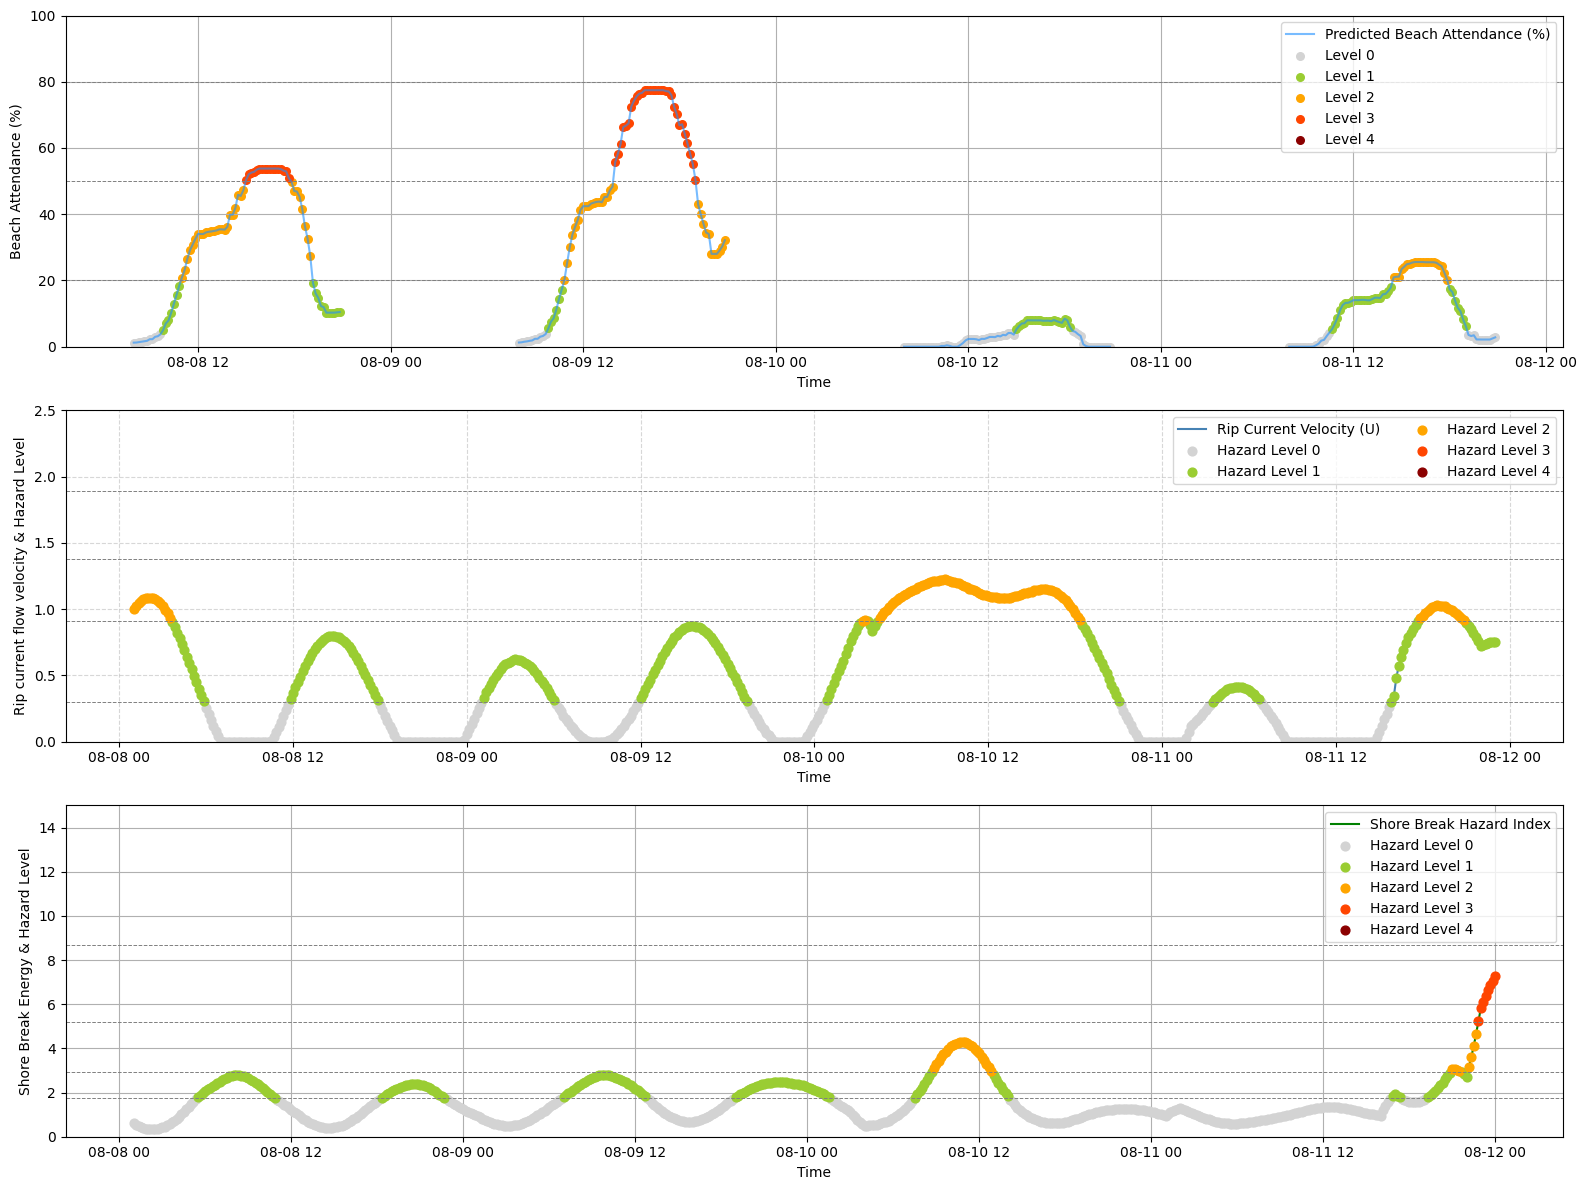

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Define the color scheme for the levels
colors = ['lightgrey', 'yellowgreen', 'orange', 'orangered', 'darkred']

plt.figure(figsize=(16, 12))

# Define threshold lines for each subplot
attendance_thresholds = [20, 50, 80]  # Example thresholds for Beach Attendance
rip_current_thresholds = [SR1, SR2, SR3, SR4]  # Already defined for Rip Current
shore_break_thresholds = [SS1, SS2, SS3, SS4]  # Already defined for Shore Break

# Subplot for Beach Attendance Prediction
plt.subplot(3, 1, 1)
plt.plot(combined_data['Datetime'], predictions_denormalized, label='Predicted Beach Attendance (%)', color='dodgerblue', linestyle='-', alpha=0.6)
for level in range(5):
    mask = pred_classes == level
    plt.scatter(combined_data['Datetime'][mask], predictions_denormalized[mask], 
                label=f'Level {level}', color=colors[level], s=30)

# Add dashed threshold lines for Beach Attendance
for threshold in attendance_thresholds:
    plt.axhline(threshold, color='gray', linestyle='--', linewidth=0.7)

plt.xlabel('Time')
plt.ylabel('Beach Attendance (%)')
plt.ylim(0, 100)
plt.legend(loc='upper right')
plt.grid(True)

# Subplot for Rip Current Velocity
plt.subplot(3, 1, 2)
plt.plot(Tide_Time[:len(U)], U, color='steelblue', label='Rip Current Velocity (U)', zorder=1)
for level in range(5):
    idx = Uh == level
    plt.scatter(np.array(Tide_Time[:len(U)])[idx], np.array(U)[idx],
                color=colors[level], label=f'Hazard Level {level}', s=40, zorder=2)

# Add dashed threshold lines for Rip Current Velocity
for threshold in rip_current_thresholds:
    plt.axhline(threshold, color='gray', linestyle='--', linewidth=0.7)

plt.xlabel('Time')
plt.ylabel('Rip current flow velocity & Hazard Level')
plt.ylim(0, 2.5)
plt.legend(loc='upper right', ncol=2)
plt.grid(True, linestyle='--', alpha=0.5)

# Subplot for Shore Break Hazard Index
plt.subplot(3, 1, 3)
plt.plot(Tide_Time, ShoreBreak_Index, color='green', label='Shore Break Hazard Index', zorder=1)

# Corrected hazard level mapping for Shore Break Hazard Index
for level in range(5):
    if level == 0:
        idx = ShoreBreak_Index <= SS1
    elif level == 1:
        idx = (ShoreBreak_Index > SS1) & (ShoreBreak_Index <= SS2)
    elif level == 2:
        idx = (ShoreBreak_Index > SS2) & (ShoreBreak_Index <= SS3)
    elif level == 3:
        idx = (ShoreBreak_Index > SS3) & (ShoreBreak_Index <= SS4)
    else:
        idx = ShoreBreak_Index > SS4
    
    plt.scatter(np.array(Tide_Time)[idx], np.array(ShoreBreak_Index)[idx],
                color=colors[level], label=f'Hazard Level {level}', s=40, zorder=2)

# Add dashed threshold lines for Shore Break Hazard Index
for threshold in shore_break_thresholds:
    plt.axhline(threshold, color='gray', linestyle='--', linewidth=0.7)

plt.xlabel('Time')
plt.ylabel('Shore Break Energy & Hazard Level')
plt.ylim(0, 15)
plt.legend(loc='upper right')
plt.grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
